In [1]:
#% pip install openpyxl
import os, re, configparser
import pandas as pd
import numpy as np
from globals import glob
from utilities_database import prepare_data, prepare_database, consult_database, clear_databases, retrieve_data, rename_index, get_date, get_sigma, rename_limits_table
from utilities_analysis import mean_calculator, limits_generator, ini_generator, RyR, z_score_filter, reset_df, capability_calculation
from utilities_plotting import plot_scatter, plot_capability, plot_simple_limits
import _db_tools as db

Database *input.db* found in: c:\Users\luciano.galan\Desktop\Codebase\Python_Eiit_RyR\a2_Analyser\database\input.db
Database *output.db* found in: c:\Users\luciano.galan\Desktop\Codebase\Python_Eiit_RyR\a2_Analyser\database\output.db


In [2]:
#Data extraction
table_names = ['TOP_PASSAT_B9_measurements_2023y_12m_13d_14h_49m_51s', 'TOP_Passat_B9_limits_corrected_2023y_12m_13d_15h_47m_46s']
MEAS = retrieve_data("input.db", table_names[0])
LIMITS = retrieve_data("output.db", table_names[1])

Table *TOP_PASSAT_B9_measurements_2023y_12m_13d_14h_49m_51s* retrieved succesfully.
Table *TOP_Passat_B9_limits_corrected_2023y_12m_13d_15h_47m_46s* retrieved succesfully.


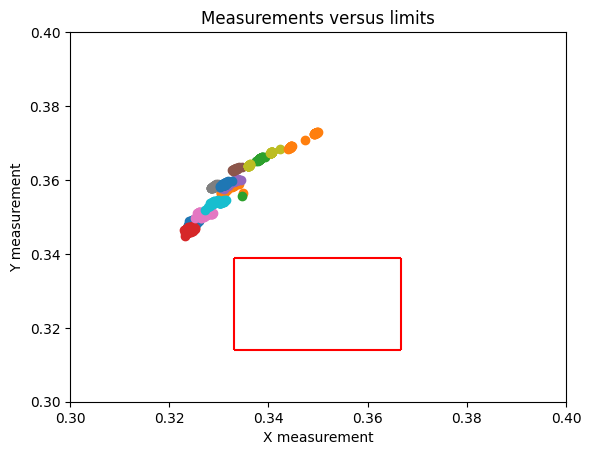

In [3]:
plot_simple_limits(MEAS, LIMITS, glob.nests_number, xrange=[0.3, 0.4], yrange=[0.3, 0.4], filter=1)